## BeamformerEA demo notebook
This notebook demonstartes the use of the BeamformerEA acoular class. The BeamformerEA reconstructs 
an acoustic field using monopole sound sources. Unlike the other beamformer in acoular, it uses a variable grid to reconstruct the sources. It can correctly find the positions and the source strengths. To achieve this goal, a global optimization problem is solved using the evolutionary algorithm differential evolution from the scipyt.optimice python package. 

Below is a synthetic data set with a monopole acoustic source evaluated with BeamformerEA, BeamformerBase and BeamformerCMF. The monoopole source shall be positioned at x_s = 0.5, y_s = 0.0, z_s = 0.75 with a rms amplitude of 1.0 in 1 m distance. The variable search gird for the source shall be defined on the x,y - surface with bounds:  x = [-1.0, 1.0] y = [-1.0, 1.0] z = [0.75, 0.75] d = [0.0, 1.0]. Where d are the bounds for the source strength 

In [1]:
from acoular import *
from os import path
from acoular import __file__ as bpath
import matplotlib.pyplot as plt

# load some array geometry
micgeofile = path.join(path.split(bpath)[0], 'xml', 'array_64.xml')
MICGEOM = MicGeom(from_file=micgeofile) 

# set sampling frequency and singal time 
SFREQ = 51200
TIME = 1
NUM_SAMPLES = TIME * SFREQ
BLOCK_SIZE = 1024

# create some exemplary synthetic data of one monopole point source
# with white noise signal. 
h5savefile = 'Test_dat.h5'
n = WNoiseGenerator(sample_freq=SFREQ, numsamples=NUM_SAMPLES, seed=0)
p = PointSource(signal=n, mics=MICGEOM, loc=(0.5,0.0,0.75))
wh5 = WriteH5(source=p, name=h5savefile)
wh5.save()

## BeamformerEA

In [48]:
# Define boundary for source position and source strength variation.
# The amount of monopole sources used for the reconstruction is defined by the 
# length of the GRID_BOUNDS array, which has to be a multiple of 4.  
# The amount of sources used for the reconstruction is then len(GRID_BOUNDS).
# GRID_BOUNDS = [(x_s1l, x_s1r),(y_s1l, y_s1r),(z_s1l, z_s1r),(d1l, d1r), ...]
# where x_s1l, x_s1r are the lower and upper bounds for the positional variation of source one
# and d1l, d1r are the bounds for its source strength variation.
# In our example we want to search for the source position and source strength in 
# the x,y plane at the fixed height z = 0.75.Therefore the third tuple contains (0.75,0.75)
# We want to use only one source, so our GRID_BOUDS is array:
GRID_BOUNDS = [(-1, 1), (-1, 1), (0.75, 0.75), (0, 1)]
# The BeamformerEA requires an MicGeom object, an PowerSpectra object and a GRID_BOUNDS array 
# for source reconstruction. In order to avoid deprecation warnings the MicGeom object will be
# passed through the SteeringVector object, which may change in the future.
SV_EA = SteeringVector(mics=MICGEOM) 
ts = TimeSamples(name='Test_dat.h5', sample_freq=SFREQ)
ps = PowerSpectra(time_data=ts, block_size=BLOCK_SIZE, window='Hanning')
bea = BeamformerEA(steer = SV_EA, freq_data=ps)

In [49]:
# The main BeamformerEA method which calculates source position and 
# source strengths on a variable Grid defined by GRID_BOUNDS in
# the narrow band with frequency 800 Hz. 
res_BEA = bea.calculate(GRID_BOUNDS, 800)

[('Test_dat_cache.h5', 5)]


In [50]:
# The BeamformerEA calculate method returns an scipy.optimize.OpimizeResult object, 
# in which x contains the found coordinates and strength of the sources used for reconstruction.
# In our exemplary case this would be: 
# res_BEA.x[0] - x - coordinate  source 1
# res_BEA.x[1] - y - coordinate  source 1
# res_BEA.x[2] - z - coordinate  source 1
# res_BEA.x[3] - source strength source 1
res_BEA

     fun: 1.7348562116697356e-07
 message: 'Optimization terminated successfully.'
    nfev: 2595
     nit: 42
 success: True
       x: array([ 4.99373287e-01, -2.85033197e-05,  7.50000000e-01,  2.64188126e-03])

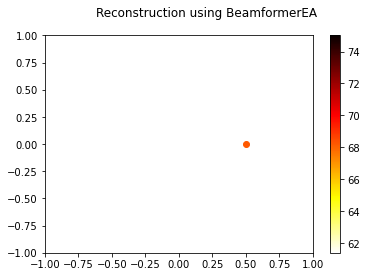

In [45]:
# For the graphical representation of the results only one point has to be plotted, 
# which can be achieved with pyplot.scatter.
plt.figure()
plt.scatter(res_BEA.x[0],res_BEA.x[1],c=L_p(res_BEA.x[3]),cmap= 'hot_r')
plt.suptitle("Reconstruction using BeamformerEA")
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.colorbar()

In [9]:
L_p(res_BEA.x[3])

68.19853514156816

As can be seen, the BeamformerEA finds the the source in the correct position. 

## BeamformerBase

[('Test_dat_cache.h5', 10)]


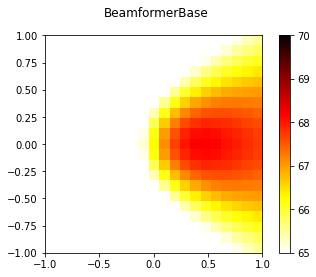

In [59]:
#define grid and steering vector for BeamformerBase and BeamformerCMF
GR = RectGrid(x_min=-1,x_max=1, y_min=-1, y_max=1, z=0.75,increment=0.1)
SV = SteeringVector(grid=GR, mics=MICGEOM)

beb = BeamformerBase(freq_data=ps,steer=SV)
res_BEB = beb.synthetic(800,0)

im = plt.imshow(L_p(res_BEB.T),vmax=70,vmin=65,extent=GR.extend(),cmap= 'hot_r')
plt.suptitle("BeamformerBase")
plt.colorbar()

## BeamformerCMF

[('Test_dat_cache.h5', 11)]


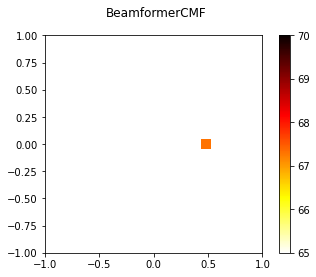

In [60]:
#becmf = BeamformerCMF(freq_data=ps,grid=GR, mpos=MICGEOM)
becmf = BeamformerCMF(freq_data=ps,steer=SV)
res_CMF = becmf.synthetic(800,0)

im = plt.imshow(L_p(res_CMF.T),vmax=70,vmin=65,extent=GR.extend(),cmap= 'hot_r')
plt.suptitle("BeamformerCMF")

plt.colorbar()

The results from BeamformerBase and BeamformerCMF are close to BeamformerEA, source position and strength are similar. Nevertheless the results are only conditionally comparable, because the BeamformerEA uses a variable grid.  